In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

<h2>Load the Coffee Sales dataset using PySpark</h2>

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.appName("CoffeeSalesAnalysis").getOrCreate()
df = spark.read.csv("Coffe_sales.csv", header=True, inferSchema=True)
df.show(5)


+-----------+---------+-----+-------------+-----------+-------+----------+-----------+---------+----------+--------------------+
|hour_of_day|cash_type|money|  coffee_name|Time_of_Day|Weekday|Month_name|Weekdaysort|Monthsort|      Date|                Time|
+-----------+---------+-----+-------------+-----------+-------+----------+-----------+---------+----------+--------------------+
|         10|     card| 38.7|        Latte|    Morning|    Fri|       Mar|          5|        3|2024-03-01|2025-10-21 10:15:...|
|         12|     card| 38.7|Hot Chocolate|  Afternoon|    Fri|       Mar|          5|        3|2024-03-01|2025-10-21 12:19:...|
|         12|     card| 38.7|Hot Chocolate|  Afternoon|    Fri|       Mar|          5|        3|2024-03-01|2025-10-21 12:20:...|
|         13|     card| 28.9|    Americano|  Afternoon|    Fri|       Mar|          5|        3|2024-03-01|2025-10-21 13:46:...|
|         13|     card| 38.7|        Latte|  Afternoon|    Fri|       Mar|          5|        3|2

<h2>Clean data and convert columns to correct data types
</h2>

In [5]:
df = df.withColumn("money", F.col("money").cast("double")) \
       .withColumn("hour_of_day", F.col("hour_of_day").cast("int")) \
       .withColumn("Monthsort", F.col("Monthsort").cast("int")) \
       .withColumn("Weekdaysort", F.col("Weekdaysort").cast("int"))
df.printSchema()

root
 |-- hour_of_day: integer (nullable = true)
 |-- cash_type: string (nullable = true)
 |-- money: double (nullable = true)
 |-- coffee_name: string (nullable = true)
 |-- Time_of_Day: string (nullable = true)
 |-- Weekday: string (nullable = true)
 |-- Month_name: string (nullable = true)
 |-- Weekdaysort: integer (nullable = true)
 |-- Monthsort: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)



<h2>Get total transactions and total revenue</h2>

In [6]:
summary = df.agg(
    F.count("*").alias("Total_Transactions"),
    F.sum("money").alias("Total_Revenue"),
    F.avg("money").alias("Average_Sale")
)
summary.show()

+------------------+------------------+-----------------+
|Total_Transactions|     Total_Revenue|     Average_Sale|
+------------------+------------------+-----------------+
|              3547|112245.57999999814|31.64521567521797|
+------------------+------------------+-----------------+



<h2>Find the most popular coffee by number of transactions</h2>

In [7]:
top_coffee = df.groupBy("coffee_name") \
               .agg(F.count("*").alias("count")) \
               .orderBy(F.desc("count"))
top_coffee.show(10)

+-------------------+-----+
|        coffee_name|count|
+-------------------+-----+
|Americano with Milk|  809|
|              Latte|  757|
|          Americano|  564|
|         Cappuccino|  486|
|            Cortado|  287|
|      Hot Chocolate|  276|
|              Cocoa|  239|
|           Espresso|  129|
+-------------------+-----+



<h2>Find busiest hours based on number of sales

In [9]:
peak_hours = df.groupBy("hour_of_day") \
               .agg(F.count("*").alias("Transactions")) \
               .orderBy(F.desc("Transactions"))
peak_hours.show(10)

+-----------+------------+
|hour_of_day|Transactions|
+-----------+------------+
|         10|         328|
|         11|         283|
|         16|         278|
|          9|         242|
|         12|         241|
|         17|         237|
|         15|         236|
|          8|         235|
|         19|         229|
|         13|         225|
+-----------+------------+
only showing top 10 rows



<h2>Compare revenue between cash and card</h2>

In [10]:
payment_summary = df.groupBy("cash_type") \
                    .agg(F.count("*").alias("Transactions"),
                         F.sum("money").alias("Total_Revenue"),
                         F.avg("money").alias("Avg_Transaction"))
payment_summary.show()


+---------+------------+------------------+-----------------+
|cash_type|Transactions|     Total_Revenue|  Avg_Transaction|
+---------+------------+------------------+-----------------+
|     card|        3547|112245.57999999814|31.64521567521797|
+---------+------------+------------------+-----------------+



<h2>Analyze number of sales grouped by Weekday and Month</h2>

In [11]:
weekday_month = df.groupBy("Weekday", "Month_name") \
                  .agg(F.count("*").alias("Transactions")) \
                  .orderBy("Month_name", "Weekday")
weekday_month.show(20)

+-------+----------+------------+
|Weekday|Month_name|Transactions|
+-------+----------+------------+
|    Fri|       Apr|          25|
|    Mon|       Apr|          29|
|    Sat|       Apr|          23|
|    Sun|       Apr|          23|
|    Thu|       Apr|          23|
|    Tue|       Apr|          26|
|    Wed|       Apr|          19|
|    Fri|       Aug|          34|
|    Mon|       Aug|          41|
|    Sat|       Aug|          47|
|    Sun|       Aug|          37|
|    Thu|       Aug|          44|
|    Tue|       Aug|          35|
|    Wed|       Aug|          34|
|    Fri|       Dec|          29|
|    Mon|       Dec|          41|
|    Sat|       Dec|          40|
|    Sun|       Dec|          43|
|    Thu|       Dec|          28|
|    Tue|       Dec|          45|
+-------+----------+------------+
only showing top 20 rows



<h2>Top-selling coffee types</h2>

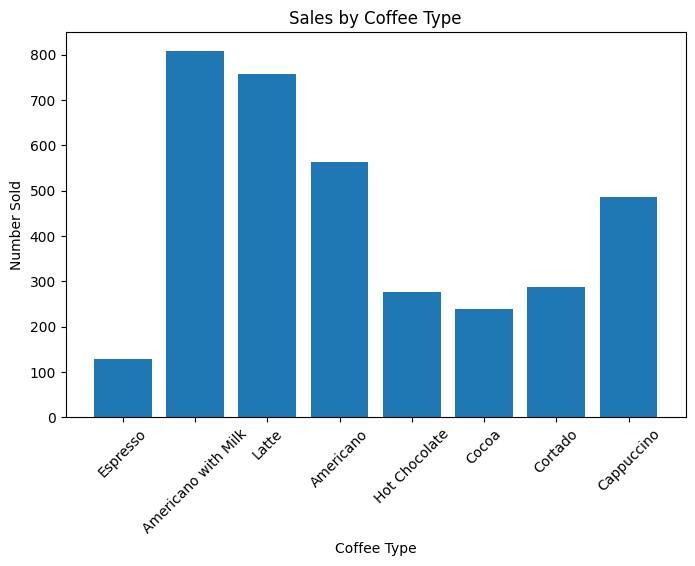

In [12]:
pdf_coffee = df.groupBy("coffee_name").agg(F.count("*").alias("count")).toPandas()

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.bar(pdf_coffee["coffee_name"], pdf_coffee["count"])
plt.title("Sales by Coffee Type")
plt.xlabel("Coffee Type")
plt.ylabel("Number Sold")
plt.xticks(rotation=45)
plt.show()

<h2>Number of transactions per hour</h2>

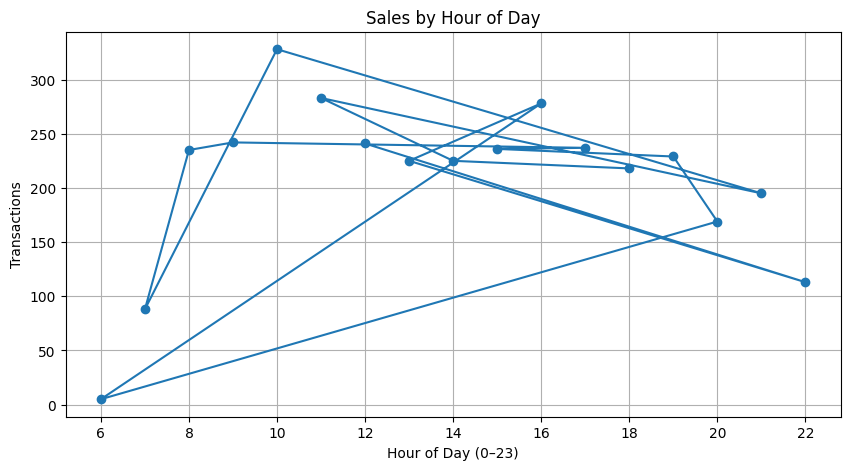

In [13]:
pdf_hour = df.groupBy("hour_of_day").agg(F.count("*").alias("count")).toPandas()

plt.figure(figsize=(10,5))
plt.plot(pdf_hour["hour_of_day"], pdf_hour["count"], marker='o')
plt.title("Sales by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Transactions")
plt.grid(True)
plt.show()

<h2>Sales by Time of Day</h2>

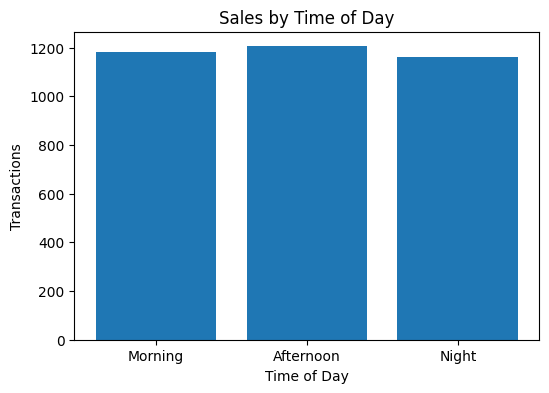

In [14]:
pdf_tod = df.groupBy("Time_of_Day").agg(F.count("*").alias("count")).toPandas()

plt.figure(figsize=(6,4))
plt.bar(pdf_tod["Time_of_Day"], pdf_tod["count"])
plt.title("Sales by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Transactions")
plt.show()

<h2>Sales by Weekday & Month</h2>

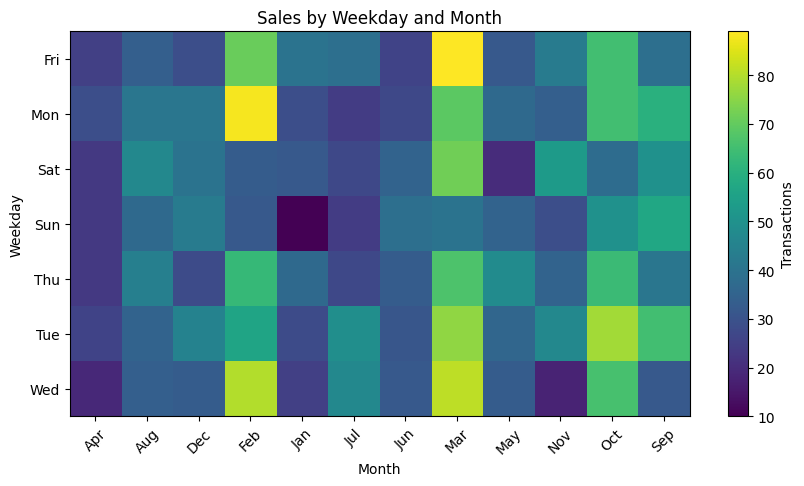

In [15]:
pdf_wm = df.groupBy("Weekday", "Month_name").agg(F.count("*").alias("count")).toPandas()
pivot_df = pdf_wm.pivot(index="Weekday", columns="Month_name", values="count").fillna(0)

plt.figure(figsize=(10,5))
plt.imshow(pivot_df, aspect='auto')
plt.title("Sales by Weekday and Month")
plt.xlabel("Month")
plt.ylabel("Weekday")
plt.xticks(range(len(pivot_df.columns)), pivot_df.columns, rotation=45)
plt.yticks(range(len(pivot_df.index)), pivot_df.index)
plt.colorbar(label="Transactions")
plt.show()

<h2>cash vs card sales distribution</h2>

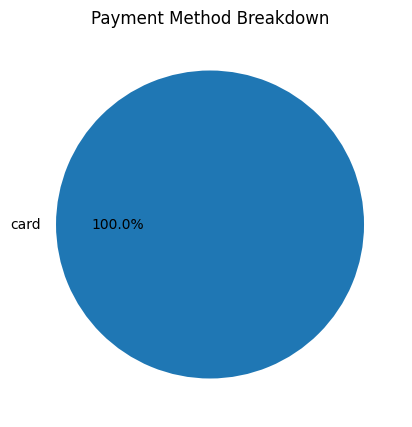

In [16]:
pdf_pay = df.groupBy("cash_type").agg(F.sum("money").alias("revenue")).toPandas()

plt.figure(figsize=(5,5))
plt.pie(pdf_pay["revenue"], labels=pdf_pay["cash_type"], autopct="%1.1f%%")
plt.title("Payment Method Breakdown")
plt.show()

<h2>Revenue Trend Over Time</h2>

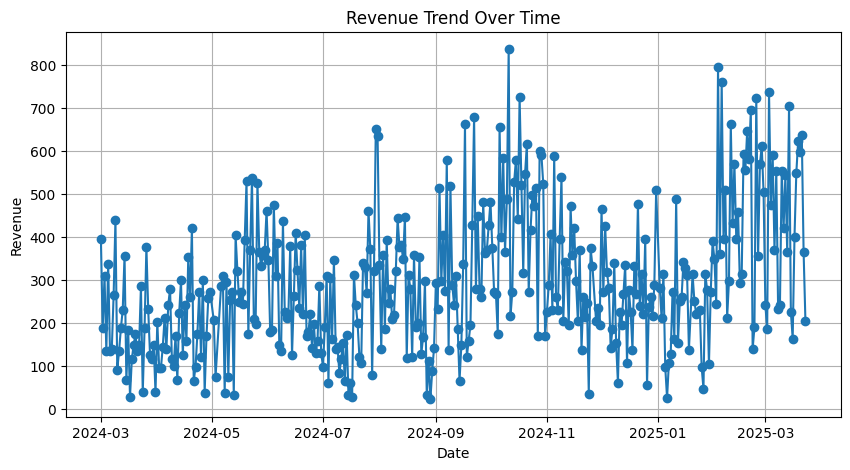

In [17]:
pdf_date = df.groupBy("Date").agg(F.sum("money").alias("revenue")).orderBy("Date").toPandas()

plt.figure(figsize=(10,5))
plt.plot(pdf_date["Date"], pdf_date["revenue"], marker='o')
plt.title("Revenue Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()